In [1]:
import sys

!{sys.executable} -m pip install torch
!{sys.executable} -m pip install qiskit
!{sys.executable} -m pip install pylatexenc
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install itertools

You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.


You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools
You should consider upgrading via the '/usr

In [2]:
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn

In [3]:
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np

In [4]:
from tqdm import tqdm

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

In [26]:
np.random.seed = 42
# np.random.seed(123)

torch.manual_seed(123)

import random
random.seed(123)

NUM_QUBITS = 7
NUM_SHOTS = 5000
SHIFT = np.pi/4
LEARNING_RATE = 0.01
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('qasm_simulator')

In [7]:
# create list of all possible outputs of quantum circuit (2**NUM_QUBITS possible)
import itertools

def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0000000', '0000001', '0000010', '0000011', '0000100', '0000101', '0000110', '0000111', '0001000', '0001001', '0001010', '0001011', '0001100', '0001101', '0001110', '0001111', '0010000', '0010001', '0010010', '0010011', '0010100', '0010101', '0010110', '0010111', '0011000', '0011001', '0011010', '0011011', '0011100', '0011101', '0011110', '0011111', '0100000', '0100001', '0100010', '0100011', '0100100', '0100101', '0100110', '0100111', '0101000', '0101001', '0101010', '0101011', '0101100', '0101101', '0101110', '0101111', '0110000', '0110001', '0110010', '0110011', '0110100', '0110101', '0110110', '0110111', '0111000', '0111001', '0111010', '0111011', '0111100', '0111101', '0111110', '0111111', '1000000', '1000001', '1000010', '1000011', '1000100', '1000101', '1000110', '1000111', '1001000', '1001001', '1001010', '1001011', '1001100', '1001101', '1001110', '1001111', '1010000', '1010001', '1010010', '1010011', '1010100', '1010101', '1010110', '1010111', '1011000', '1011001', '1011010'

# Contruct QuantumCircuit QFT Class

In [8]:
class QuantumCircuit:
    def __init__(self, n_qubits, backend, shots):
        self.n_qubits = n_qubits
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.thetas = { k: Parameter('Theta'+str(k)) for k in range(self.n_qubits) }
        
        all_qubits = [i for i in range(n_qubits)]
        
        self.circuit.h(all_qubits)
        self.circuit.barrier()
        for k in range(n_qubits):
            self.circuit.ry(self.thetas[k], k)
            
        self.circuit.measure_all()
        
        self.backend = backend
        self.shots = shots
        
    def N_qubits_expectation_Z(self, counts, shots, n_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0) / shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
        
        backend = Aer.get_backend('qasm_simulator')
        
        job_sim = execute(self.circuit, 
                          self.backend, 
                          shots = self.shots, 
                          parameter_binds = [{ self.thetas[k]: params[k].item() for k in range(self.n_qubits) }])
        
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        
        return self.N_qubits_expectation_Z(counts, self.shots, self.n_qubits)

Expected value for rotation [pi/4]: [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 4.000e-04 0.000e+00 0.000e+00 0.000e+00 4.000e-04 2.000e-04 6.000e-04
 2.000e-04 1.200e-03 0.000e+00 0.000e+00 0.000e+00 8.000e-04 0.000e+00
 2.000e-04 4.000e-04 1.000e-03 0.000e+00 0.000e+00 6.000e-04 2.000e-03
 4.000e-04 1.600e-03 8.000e-04 1.060e-02 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 2.000e-04 6.000e-04 1.000e-03 2.000e-04 6.000e-04
 4.000e-04 1.800e-03 6.000e-04 1.800e-03 2.000e-03 9.000e-03 0.000e+00
 4.000e-04 0.000e+00 1.600e-03 0.000e+00 8.000e-04 1.600e-03 1.200e-02
 2.000e-04 6.000e-04 2.200e-03 9.400e-03 2.200e-03 9.400e-03 1.240e-02
 6.080e-02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e-04 0.000e+00
 0.000e+00 1.600e-03 0.000e+00 6.000e-04 6.000e-04 1.400e-03 4.000e-04
 1.400e-03 1.400e-03 1.100e-02 0.000e+00 2.000e-04 6.000e-04 1.800e-03
 0.000e+00 2.200e-03 1.400e-03 1.200e-02 0.000e+00 2.600e-03 1.600e-03
 1.060e-02 1.800e-03 9.600e-03 8.800e-03 

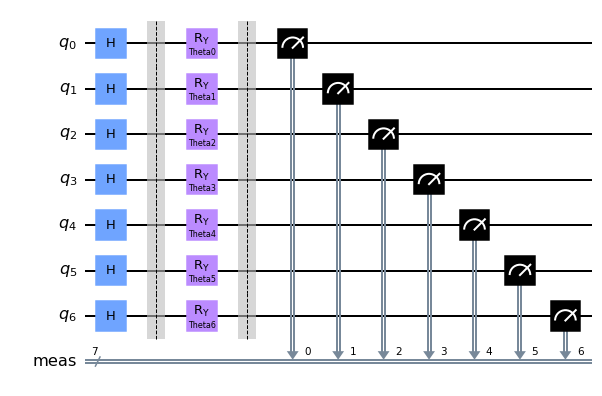

In [9]:
circuit = QuantumCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
print(f'Expected value for rotation [pi/4]: {circuit.run(torch.Tensor([np.pi/4] * len(QC_OUTPUTS)))}')
circuit.circuit.draw(output='mpl')

In [10]:
class TorchCircuit(Function):
    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QuantumCircuit'):
            ctx.QuantumCircuit = QuantumCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
        
        exp_value = ctx.QuantumCircuit.run(i)
        
        result = torch.Tensor([exp_value])
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        forward_tensor,i = ctx.saved_tensors
        
        input_numbers = i
        gradients = torch.Tensor()
        
        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
            expectation_right = ctx.QuantumCircuit.run(shift_right)
            expectation_left = ctx.QuantumCircuit.run(shift_left)
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradient = gradient / torch.norm(gradient)
            
            gradients = torch.cat((gradients, gradient.float()))
            
        result = torch.Tensor(gradients)
        
        return (result.float() * grad_output.float()).T

In [11]:
x = torch.tensor([np.pi/4] * NUM_QUBITS, requires_grad=True)
qc = TorchCircuit.apply

y1 = qc(x)
print(f'y1 after quantum layer: {y1}')
y1 = nn.Linear(2**NUM_QUBITS, 1)(y1.float())

y1.backward()
print(f'x.grad = {x.grad}')

y1 after quantum layer: tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e-04,
         0.0000e+00, 2.0000e-04, 6.0000e-04, 1.4000e-03, 0.0000e+00, 2.0000e-04,
         0.0000e+00, 2.0000e-04, 0.0000e+00, 2.0000e-04, 2.0000e-04, 2.0000e-03,
         0.0000e+00, 2.0000e-04, 4.0000e-04, 1.8000e-03, 4.0000e-04, 1.8000e-03,
         1.0000e-03, 9.6000e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.0000e-04, 2.0000e-04, 2.0000e-04, 4.0000e-04, 0.0000e+00, 4.0000e-04,
         2.0000e-04, 2.4000e-03, 4.0000e-04, 2.0000e-03, 1.4000e-03, 9.2000e-03,
         2.0000e-04, 2.0000e-04, 2.0000e-04, 2.4000e-03, 2.0000e-04, 1.6000e-03,
         2.2000e-03, 8.4000e-03, 4.0000e-04, 1.6000e-03, 1.4000e-03, 8.8000e-03,
         2.0000e-03, 1.0600e-02, 1.0200e-02, 5.7000e-02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 2.0000e-04, 0.0000e+00, 2.0000e-04, 0.0000e+00, 2.2000e-03,
    

100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


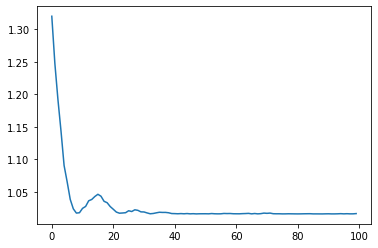

In [12]:
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)[0]
    
    val = sum([(i + 1) * expval[i] for i in range(2**NUM_QUBITS)]) / 2**NUM_QUBITS
    
    return torch.abs(target - val) ** 2, expval


x = torch.tensor([-np.pi/4] * NUM_QUBITS, requires_grad=True)
opt = optim.Adam([x], lr = 0.1)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval)
    
plt.plot(loss_list)

In [13]:
from torch.functional import F

In [14]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

n_samples = 150

X_train = datasets.FashionMNIST(root='./data', 
                                train=True,
                                download=True,
                                transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 2)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 3)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 4)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 5)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 6)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 7)[0][:n_samples])
# idx = np.append(idx, 
#                 np.where(X_train.targets == 8)[0][:n_samples])
# idx = np.append(idx, 
#                 np.where(X_train.targets == 9)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

In [15]:
train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

In [16]:
n_samples = 100

X_test = datasets.FashionMNIST(root='./data', 
                               train=False,
                               download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 2)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 3)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 4)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 5)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 6)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 7)[0][:n_samples])
# idx = np.append(idx, 
#                 np.where(X_test.targets == 8)[0][:n_samples])
# idx = np.append(idx, 
#                 np.where(X_test.targets == 9)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

In [17]:
test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

# Building network

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, NUM_QUBITS)
        self.qc = TorchCircuit.apply
        self.qcsim = nn.Linear(NUM_QUBITS, 2**NUM_QUBITS)
        
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = np.pi*torch.tanh(x)
        
        MODE = 'QC'
        
        if MODE == 'QC':
            x = self.qc(x[0])
        else:
            x = self.qcsim(x)
            
        x = torch.sigmoid(x)
        x = torch.cat((x, 1-x), -1)
        
        return x
    
    
    def predict(self, x):
        
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        
        return torch.tensor(ans)
    
network = Net()
optimizer = optim.Adam(network.parameters(), lr=0.001)

In [19]:
epochs = 15
loss_list = []
loss_func = nn.CrossEntropyLoss()

for epoch in range(epochs):
    total_loss = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss.append(loss.item())
        
    loss_list.append(sum(total_loss) / len(total_loss))
    progress = 100.0 * (epoch + 1) / epochs
    
    print(f'Training [{int(progress)}%]\tLoss {loss_list[-1]}')

Training [6%]	Loss 5.5011626120408375
Training [13%]	Loss 5.459279278516769
Training [20%]	Loss 5.443509957393011
Training [26%]	Loss 5.432433512210846
Training [33%]	Loss 5.428064612547557
Training [40%]	Loss 5.424477171897888
Training [46%]	Loss 5.422092487017314
Training [53%]	Loss 5.421164606412252
Training [60%]	Loss 5.414508510430654
Training [66%]	Loss 5.415812835295995
Training [73%]	Loss 5.417482693592707
Training [80%]	Loss 5.411955973704656
Training [86%]	Loss 5.4133091485500335
Training [93%]	Loss 5.412428843975067
Training [100%]	Loss 5.41105088353157


Text(0, 0.5, 'loss')

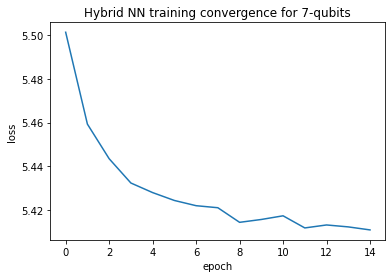

In [20]:
plt.plot(loss_list)
plt.title(f'Hybrid NN training convergence for {NUM_QUBITS}-qubits')
plt.xlabel('epoch')
plt.ylabel('loss')

# Test accuracy

In [21]:
accuracy = 0
number = 0
for batch_idx, (data, target) in enumerate(test_loader):
    number += 1
    output = network.predict(data).item()
    accuracy += (output == target[0].item())*1

In [22]:
print(f'Performance on test data: {accuracy}/{number} = {accuracy/number*100}%')

Performance on test data: 522/800 = 65.25%


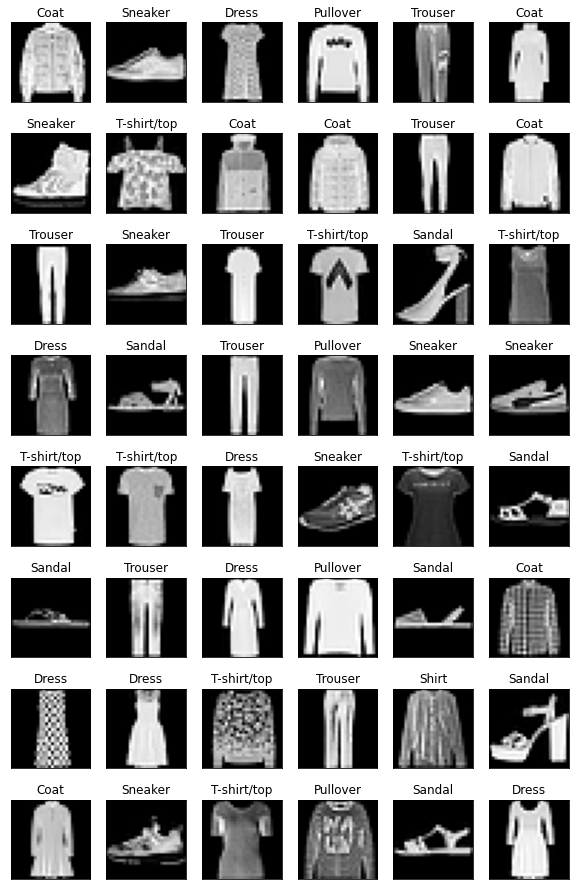

In [23]:
n_sample_shape = (8, 6)
count = 0
fig, axes = plt.subplots(nrows=n_sample_shape[0], ncols=n_sample_shape[1], figsize=(10, 2*n_sample_shape[0]))

classes_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

network.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_sample_shape[0]*n_sample_shape[1]:
            break
        
        prediction = network.predict(data).item()
        
        axes[count // n_sample_shape[1]][count % n_sample_shape[1]].imshow(data[0].numpy().squeeze(), cmap='gray')
        
        axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_xticks([])
        axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_yticks([])
        axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_title(classes_map[prediction])
        
        count += 1

In [24]:
def train_network(network, optimizer, train_loader, val_loader):
    epochs = 15
    loss_func = nn.CrossEntropyLoss()

    loaders = {
        'train': train_loader,
        'val': val_loader
    }
    
    loss_results = {
        'train': [],
        'val': []
    }

    acc_results = {
        'train': [],
        'val': []
    }

    loaders = {
        'train': train_loader,
        'val': test_loader
    }

    for epoch in range(epochs):
        total_loss = {
            'train': [],
            'val': []
        }

        total_acc = {
            'train': [],
            'val': []
        }


        for phase in ['train', 'val']:
            if phase == 'train':
                network.train(True)
            else:
                network.train(False)

            correct = 0
            number = 0

            for batch_idx, (data, target) in enumerate(loaders[phase]):
                optimizer.zero_grad()
                output = network(data)

                loss = loss_func(output, target)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                total_loss[phase].append(loss.item())

                _, predicted = torch.max(output.data, 1)
                number += target.size(0)
                correct += (predicted == target).sum().item()

            loss_results[phase].append(sum(total_loss[phase]) / len(total_loss[phase]))
            acc_results[phase].append(100 * correct / number)

        progress = 100.0 * (epoch + 1) / epochs

        print(f'Training [{int(progress)}%]\tTraining loss {loss_results["train"][-1]}\tValidation loss {loss_results["val"][-1]}\tTraining acc {acc_results["train"][-1]}\tValidation acc {acc_results["val"][-1]}')
        
    return {
        'train_loss': loss_results["train"][-1],
        'val_loss': loss_results["val"][-1],
        'train_acc': acc_results["train"][-1],
        'val_acc': acc_results["val"][-1]
    }

In [27]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, ConcatDataset

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

dataset = ConcatDataset([X_train, X_test])

k_folds = 5

kfold = KFold(n_splits=k_folds, shuffle=True)

results = {}

print('--------------------------------')

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
  
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=1, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=1, sampler=test_subsampler)

    network = Net()
    network.apply(reset_weights)
    
    optimizer = optim.Adam(network.parameters(), lr=0.001)
    
    result = train_network(network, optimizer, trainloader, testloader)
    
    results[fold] = result
    
    print(result)
    print('--------------------------------')

print('--------------------------------')
print('FINAL RESULTS')
print('--------------------------------')
print(results)
    

--------------------------------
FOLD 0
--------------------------------
Training [6%]	Training loss 5.49833936303854	Validation loss 5.441791173219681	Training acc 26.9375	Validation acc 51.25
Training [13%]	Training loss 5.458181408941746	Validation loss 5.420347974896431	Training acc 46.8125	Validation acc 56.0
Training [20%]	Training loss 5.442332144975662	Validation loss 5.419851938486099	Training acc 53.8125	Validation acc 58.0
Training [26%]	Training loss 5.431468665897846	Validation loss 5.397840101122856	Training acc 59.0	Validation acc 71.25
Training [33%]	Training loss 5.423221558630466	Validation loss 5.398538545966148	Training acc 64.4375	Validation acc 69.5
Training [40%]	Training loss 5.419060621857643	Validation loss 5.389500125050545	Training acc 65.375	Validation acc 73.875
Training [46%]	Training loss 5.417569735348224	Validation loss 5.386686316132545	Training acc 66.375	Validation acc 74.125
Training [53%]	Training loss 5.4132812479138375	Validation loss 5.38284789

Training [13%]	Training loss 5.4547602173686025	Validation loss 5.42725249350071	Training acc 47.4375	Validation acc 56.25
Training [20%]	Training loss 5.445836896896362	Validation loss 5.42459952890873	Training acc 51.375	Validation acc 58.5
Training [26%]	Training loss 5.437993890941143	Validation loss 5.407725423574448	Training acc 55.5625	Validation acc 64.75
Training [33%]	Training loss 5.434716058969498	Validation loss 5.400341516137123	Training acc 57.5	Validation acc 68.875
Training [40%]	Training loss 5.427019513249397	Validation loss 5.409521608948707	Training acc 60.375	Validation acc 64.0
Training [46%]	Training loss 5.423562053740024	Validation loss 5.391238732933998	Training acc 62.1875	Validation acc 72.5
Training [53%]	Training loss 5.420660488307476	Validation loss 5.390820809006691	Training acc 63.6875	Validation acc 70.5
Training [60%]	Training loss 5.418430722951889	Validation loss 5.387374507784844	Training acc 64.75	Validation acc 74.0
Training [66%]	Training loss